In [1]:
import numpy as np
import matplotlib.pyplot as plt
import batman
import emcee as mc
import corner
from astropy.io import fits
from multiprocessing import Pool
from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

In [2]:
## Loading in the extracted, binned spectral lighcurves
tsdata = np.load('/home/mmmurphy/data/hd219666b/reduced_data/Transit_Spectra_NoFirst_Visit3_10bins.npz')
times = tsdata['time']
rawfluxes = tsdata['flux']
rawerrors = tsdata['error']
scandirs = tsdata['scandir']
wavelengths = tsdata['WaveCenters']  # [microns]
    
t_visit = times - times[0]
# Pull out times [in day; MJD] of each orbit
orbit_ends = np.array([17, 34, 51])
orbit2times = times[:orbit_ends[0]]
orbit3times = times[orbit_ends[0] : orbit_ends[1]]
orbit4times = times[orbit_ends[1] : orbit_ends[2]]

# From above, compute time since beginning of orbit for each
tinorbit2 = orbit2times - orbit2times[0]
tinorbit3 = orbit3times - orbit3times[0]
tinorbit4 = orbit4times - orbit4times[0]
t_orbit = np.concatenate((tinorbit2, tinorbit3, tinorbit4))

fluxes = np.copy(rawfluxes)
errors = np.copy(rawerrors)
Nbins = rawfluxes.shape[0]
for wav in range(Nbins):
    sd1_idxs = np.where(scandirs == 1.)[0]
    sd0_idxs = np.where(scandirs == 0.)[0]
    
    normval1 = np.median(fluxes[wav, sd1_idxs])
    normval0 = np.median(fluxes[wav, sd0_idxs])
    
    fluxes[wav, sd1_idxs] /= normval1
    errors[wav, sd1_idxs] /= normval1
    fluxes[wav, sd0_idxs] /= normval0
    errors[wav, sd0_idxs] /= normval0

error_correction_factor = 2.97
errors /= error_correction_factor   
Npoints = fluxes.shape[1]
Nwaves = fluxes.shape[0]

In [3]:
print('Timing Info -----------------------')
print('Time of first scan: ', times[0])
print('Time of last scan: ', times[-1])
print('Number of scans total:', len(times))
print('N scans per orbit: ', len(orbit2times), len(orbit3times), len(orbit4times))
print('Avg. orbit duration [min]: ', np.mean([(orbit2times[-1]-orbit2times[0]),
                                       (orbit3times[-1]-orbit3times[0]),
                                       (orbit4times[-1]-orbit4times[0])
                                       ])*24.*60.)
print('Data Info ---------------------------')
mean_err, sd_err = norm.fit(errors)
print('Errors scaled by dividing by factor of %.1f'%(error_correction_factor))
print('Mean flux uncertainty [ppm]: ', mean_err*1.e6)
print('Scatter in flux uncertainty [ppm]: ', sd_err*1.e6)

Timing Info -----------------------
Time of first scan:  2458799.8209165093
Time of last scan:  2458799.985777947
Number of scans total: 51
N scans per orbit:  17 17 17
Avg. orbit duration [min]:  40.530467703938484
Data Info ---------------------------
Errors scaled by dividing by factor of 3.0
Mean flux uncertainty [ppm]:  162.04112997621615
Scatter in flux uncertainty [ppm]:  7.525751007797629


In [4]:
##
# Defining my parameter arrays (inits, priors, etc)
# I'll fix all of the orbital parameters to values gotten from my broadband fitting
# Here, I'll only fit the transit depths and systematic parameters
# I should also look into using single systematics based on broadband fitting too
rprs_init, rprs_init_unc = 0.0429416, 0.00033254

t0_fixed = 2458329.2016137  # [day]
P_fixed =  10. ** 0.780639       # [day]
a_fixed = 10. ** 1.12013           # [Rs]
inc_fixed = (180. / np.pi) * np.arccos(np.fabs(0.0633181))   # [degrees]
ecc_fixed = 0.
w_fixed = 90.
u_fixed = [0.16, 0.31]

amplitude_o2_init, amperr_o2_init = 0.001648, 0.0005
amplitude_o3_init, amperr_o3_init = 0.001399, 0.0005
    
tau_o2_init, tauerr_o2_init = -0.00649, 0.0005
tau_o3_init, tauerr_o3_init = -0.00576, 0.0005

slope_init, slopeerr_init = -0.0030057, 0.001
intcpt_init, intcpterr_init =  1.00079, 0.001

# Initializing the BATMAN model
InitParams = batman.TransitParams()
InitParams.t0 = t0_fixed     
InitParams.per = P_fixed
InitParams.a = a_fixed
InitParams.inc = inc_fixed
InitParams.rp = rprs_init
InitParams.ecc = ecc_fixed
InitParams.w = w_fixed
InitParams.limb_dark = 'quadratic'
InitParams.u = u_fixed
BATMAN_initmodel = batman.TransitModel(InitParams, times)

In [5]:
##
# Defining my astrophysical models

def transit(rprs, initmodel):
    # Transit Light curve model
    # Inputs:
    # theta = array of lightcurve parameters
    # initmodel = pre-initialized BATMAN model environment, which increases efficiency
    
    # Unpack input parameters
    tc = t0_fixed       # time of conjunction [days]
    P = P_fixed  # compute Period in [day]
    a = a_fixed  # compute a/Rstar
    inc = inc_fixed  # Compute inclination in [deg]
    ecc = ecc_fixed    # use these if assuming circular orbit
    omega = w_fixed
    rprstar = np.copy(rprs)
        
    # Set batman parameters
    params = batman.TransitParams()
    params.t0 = tc             # transit midpoint [day]
    params.per = P    # log10 (period [day])
    params.rp = rprstar
    params.a = a      # log10 (semi major axis [Rstar])
    params.inc = inc  # cosine inclination [degrees]
    params.ecc = ecc
    params.w = omega
    params.limb_dark = 'quadratic'
    params.u = u_fixed
    
    lightcurve = initmodel.light_curve(params)
    return lightcurve



##
# Defining my systematic models
def hook(theta, torbit):
    # Orbit-long charge trapping hook model for HST
    # Inputs:
    # theta = array of lightcurve parameters
    # torbit = time since start of corresponding orbit in units [day]
    
    amplitude2 = theta[1]
    amplitude3 = theta[2]
    tau2 = theta[3]
    tau3 = theta[4]
    
    hookcurve = np.zeros(len(t_orbit))
    hookcurve[:17] = 1. - amplitude2*np.exp(torbit[:17]/tau2)
    hookcurve[17:] = 1. - amplitude3*np.exp(torbit[17:]/tau3)
    return hookcurve

def ramp(theta, tvisit):
    # Visit-long linear model for flux in time
    slope = theta[5]
    intercept = theta[6]
    
    y = intercept + (slope*tvisit)
    return y

In [6]:
def logLikelihood(ydata, yerr, modely):
    lnL = 0.
    chi_array = ((ydata - modely) ** 2. / yerr ** 2.) + np.log(2. * np.pi * yerr ** 2.)
    lnL += -0.5 * np.sum(chi_array)
    
    return lnL

def logPriors(theta, priors, priorserr):
    
    # Limits on certain parameters
    if not (0. <= theta[0] <= 1.): return -np.inf
    # compute priors
    lnP = 0.
    for i, priorval in enumerate(priors):
        if np.isinf(priorval):
            # If not applying a prior on a parameter, it's listed as inf in the array
            lnP += 0 #continue
        else:
            lnP += -(theta[i] - priorval) ** 2. / (2. * priorserr[i] ** 2.) - np.log(np.sqrt(2. * priorserr[i] **2. * np.pi))
            #-0.5*((priorval-theta[i])**2/(priorserr[i]**2)) - np.log(np.sqrt(2.*np.pi*priorserr[i]*priorserr[i]))
    return lnP

def lnPosterior(theta, tvisit, torbit, flux_array, unc_array, prior_array, priorerrs_array):
        
    tran_model = transit(theta[0], BATMAN_initmodel)
    hook_model = hook(theta, torbit)
    ramp_model = ramp(theta, tvisit)
    model = tran_model * hook_model * ramp_model
        
    lnlikelihood = logLikelihood(mc_flux, mc_errs, model)
    
#     # Compute and check priors
    lnPrior_value = logPriors(theta, prior_array, priorerrs_array)
#     if not np.isfinite(lnPrior_value):
#         return -np.inf

    # Compute posterior
    lnPost = lnlikelihood + lnPrior_value
    
    if (np.isnan(lnPost)):
        return -np.inf
    else:
        return lnPost

In [7]:
res = {
    'spec0':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec1':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec2':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec3':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec4':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec5':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec6':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec7':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec8':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec9':{
        'fits': np.array([]),
        'errs': np.array([])
    }
}

In [8]:
rerun = True
saveVals = True

if rerun:
    Nburn = 5000
    Nsteps = 20000
    for wav in range(Nwaves):
        print('on bin ', wav)
        # set up initial values and priors
        theta_init = np.array([rprs_init, amplitude_o2_init, amplitude_o3_init, tau_o2_init, tau_o3_init, slope_init, intcpt_init])
        priorerrs = np.array([rprs_init_unc, amperr_o2_init, amperr_o3_init, tauerr_o2_init, tauerr_o3_init, slopeerr_init, intcpterr_init])
        # define mcmc global inputs
        mc_flux, mc_errs = fluxes[wav,:], errors[wav,:]
        mc_priors = np.array([np.inf, amplitude_o2_init, amplitude_o3_init, tau_o2_init, tau_o3_init, slope_init, intcpt_init])
        mc_priorserr = np.copy(priorerrs)
        # compute initial posterior
        lnPost_init = lnPosterior(theta_init, t_visit, t_orbit, mc_flux, mc_errs, mc_priors, mc_priorserr)
        print(lnPost_init)

        # Setting up and initializing MCMC
        Ndimensions = len(theta_init)
        Nwalkers = 2*Ndimensions

        # Initializing walker positions
        pos = np.zeros((Nwalkers, Ndimensions))
        for i in range(Ndimensions):
            pos[:,i] = theta_init[i] + 0.5*np.random.normal(0., priorerrs[i], Nwalkers)
        print('running burn-in')
        with Pool() as pool: 
            sampler = mc.EnsembleSampler(Nwalkers, Ndimensions, lnPosterior, pool=pool, 
                                        args=(t_visit, t_orbit, mc_flux, mc_errs, mc_priors, mc_priorserr))
            sampler.run_mcmc(pos, Nburn, progress=True);

        samples = sampler.get_chain()
        flatsamples = sampler.get_chain(flat=True)
        burn = int(Nburn-100)
        samples = samples[burn:]
        flatsamples = flatsamples[burn*Nwalkers:]

        burn_vals = np.asarray([np.median(flatsamples[:,i]) for i in range(samples.shape[2])])
        burn_err = np.asarray([np.percentile(flatsamples[:,i], 84) for i in range(samples.shape[2])]) - burn_vals

        pos = np.zeros((Nwalkers, Ndimensions))
        for i in range(Ndimensions):
            pos[:,i] = burn_vals[i] + 0.5*np.random.normal(0., burn_err[i], Nwalkers)
        print('running mcmc')
        with Pool() as pool: 
            sampler = mc.EnsembleSampler(Nwalkers, Ndimensions, lnPosterior, pool=pool,
                                        args=(t_visit, t_orbit, mc_flux, mc_errs, mc_priors, mc_priorserr))
            sampler.run_mcmc(pos, Nsteps, progress=True);\

        samples = sampler.get_chain()
        flatsamples = sampler.get_chain(flat=True)

        burn = 0
        samples = samples[burn:]
        flatsamples = flatsamples[burn*Nwalkers:]

        param_fits = np.asarray([np.median(flatsamples[:,i]) for i in range(samples.shape[2])])
        param_uperrs = np.asarray([np.percentile(flatsamples[:,i], 84) for i in range(samples.shape[2])]) - param_fits
        param_loerrs = param_fits - np.asarray([np.percentile(flatsamples[:,i], 16) for i in range(samples.shape[2])])
        gausserrs = np.mean((param_uperrs, param_loerrs), axis=0)

        depth_chain = flatsamples[:,0] ** 2.
        depth_fit = np.median(depth_chain)
        depth_uperr = np.percentile(depth_chain, 84) - depth_fit
        depth_loerr = depth_fit - np.percentile(depth_chain, 16)
        depth_err = np.mean((depth_uperr, depth_loerr))
        param_fits = np.append(param_fits, depth_fit)
        gausserrs = np.append(gausserrs, depth_err)

        res['spec'+str(wav)]['fits'] = param_fits
        res['spec'+str(wav)]['errs'] = gausserrs
        if saveVals:
            path = '/home/mmmurphy/data/hd219666b/mcmc_results/tspec/'
            sfile = path+'samples_10bins_wav'+str(wav)+'.npy'
            ffile = path+'flatsamples_10bins_wav'+str(wav)+'.npy'
            #tfile = path+'autocorrtimes_wav'+str(wav)+'.npy'
            np.save(sfile, samples)
            np.save(ffile, flatsamples)
            #np.save(tfile, autocorrtimes)
            print('chains saved to ', path)

on bin  0
323.90793399570174
running burn-in


100%|██████████| 5000/5000 [00:08<00:00, 561.63it/s]

running mcmc



100%|██████████| 20000/20000 [00:35<00:00, 566.84it/s]


chains saved to  /home/mmmurphy/data/hd219666b/mcmc_results/tspec/
on bin  1
280.5699564307905
running burn-in


100%|██████████| 5000/5000 [00:08<00:00, 563.42it/s]

running mcmc



100%|██████████| 20000/20000 [00:35<00:00, 563.95it/s]


chains saved to  /home/mmmurphy/data/hd219666b/mcmc_results/tspec/
on bin  2
368.16317765309725
running burn-in


100%|██████████| 5000/5000 [00:08<00:00, 560.34it/s]

running mcmc



100%|██████████| 20000/20000 [00:35<00:00, 562.93it/s]


chains saved to  /home/mmmurphy/data/hd219666b/mcmc_results/tspec/
on bin  3
382.32289161473983
running burn-in


100%|██████████| 5000/5000 [00:08<00:00, 560.73it/s]

running mcmc



100%|██████████| 20000/20000 [00:35<00:00, 565.54it/s]


chains saved to  /home/mmmurphy/data/hd219666b/mcmc_results/tspec/
on bin  4
416.10058121633244
running burn-in


100%|██████████| 5000/5000 [00:09<00:00, 555.42it/s]

running mcmc



100%|██████████| 20000/20000 [00:35<00:00, 564.41it/s]


chains saved to  /home/mmmurphy/data/hd219666b/mcmc_results/tspec/
on bin  5
413.59591875583425
running burn-in


100%|██████████| 5000/5000 [00:08<00:00, 563.64it/s]

running mcmc



100%|██████████| 20000/20000 [00:35<00:00, 565.15it/s]


chains saved to  /home/mmmurphy/data/hd219666b/mcmc_results/tspec/
on bin  6
411.79465380092523
running burn-in


100%|██████████| 5000/5000 [00:08<00:00, 564.55it/s]

running mcmc



100%|██████████| 20000/20000 [00:35<00:00, 565.25it/s]


chains saved to  /home/mmmurphy/data/hd219666b/mcmc_results/tspec/
on bin  7
351.24681929231434
running burn-in


100%|██████████| 5000/5000 [00:08<00:00, 568.30it/s]

running mcmc



100%|██████████| 20000/20000 [00:35<00:00, 564.18it/s]


chains saved to  /home/mmmurphy/data/hd219666b/mcmc_results/tspec/
on bin  8
384.37758829757126
running burn-in


100%|██████████| 5000/5000 [00:08<00:00, 565.68it/s]

running mcmc



100%|██████████| 20000/20000 [00:35<00:00, 565.37it/s]


chains saved to  /home/mmmurphy/data/hd219666b/mcmc_results/tspec/
on bin  9
387.0521094335362
running burn-in


100%|██████████| 5000/5000 [00:08<00:00, 564.40it/s]

running mcmc



100%|██████████| 20000/20000 [00:35<00:00, 564.65it/s]


chains saved to  /home/mmmurphy/data/hd219666b/mcmc_results/tspec/


In [9]:
loadChains = True
if loadChains:
    path = '/home/mmmurphy/data/hd219666b/mcmc_results/tspec/'
    ffile0 = path+'flatsamples_10bins_wav'+str(0)+'.npy'
    void = np.load(ffile0)
    
    rprs_flatsamples = np.zeros((void.shape[0], Nwaves))
    for wav in range(Nwaves):
        ffile = path+'flatsamples_10bins_wav'+str(wav)+'.npy'
        fsamp = np.load(ffile)
        rprs_chain = fsamp[:,0]
        rprs_flatsamples[:,wav] = rprs_chain
        
        del fsamp, rprs_chain
        
    

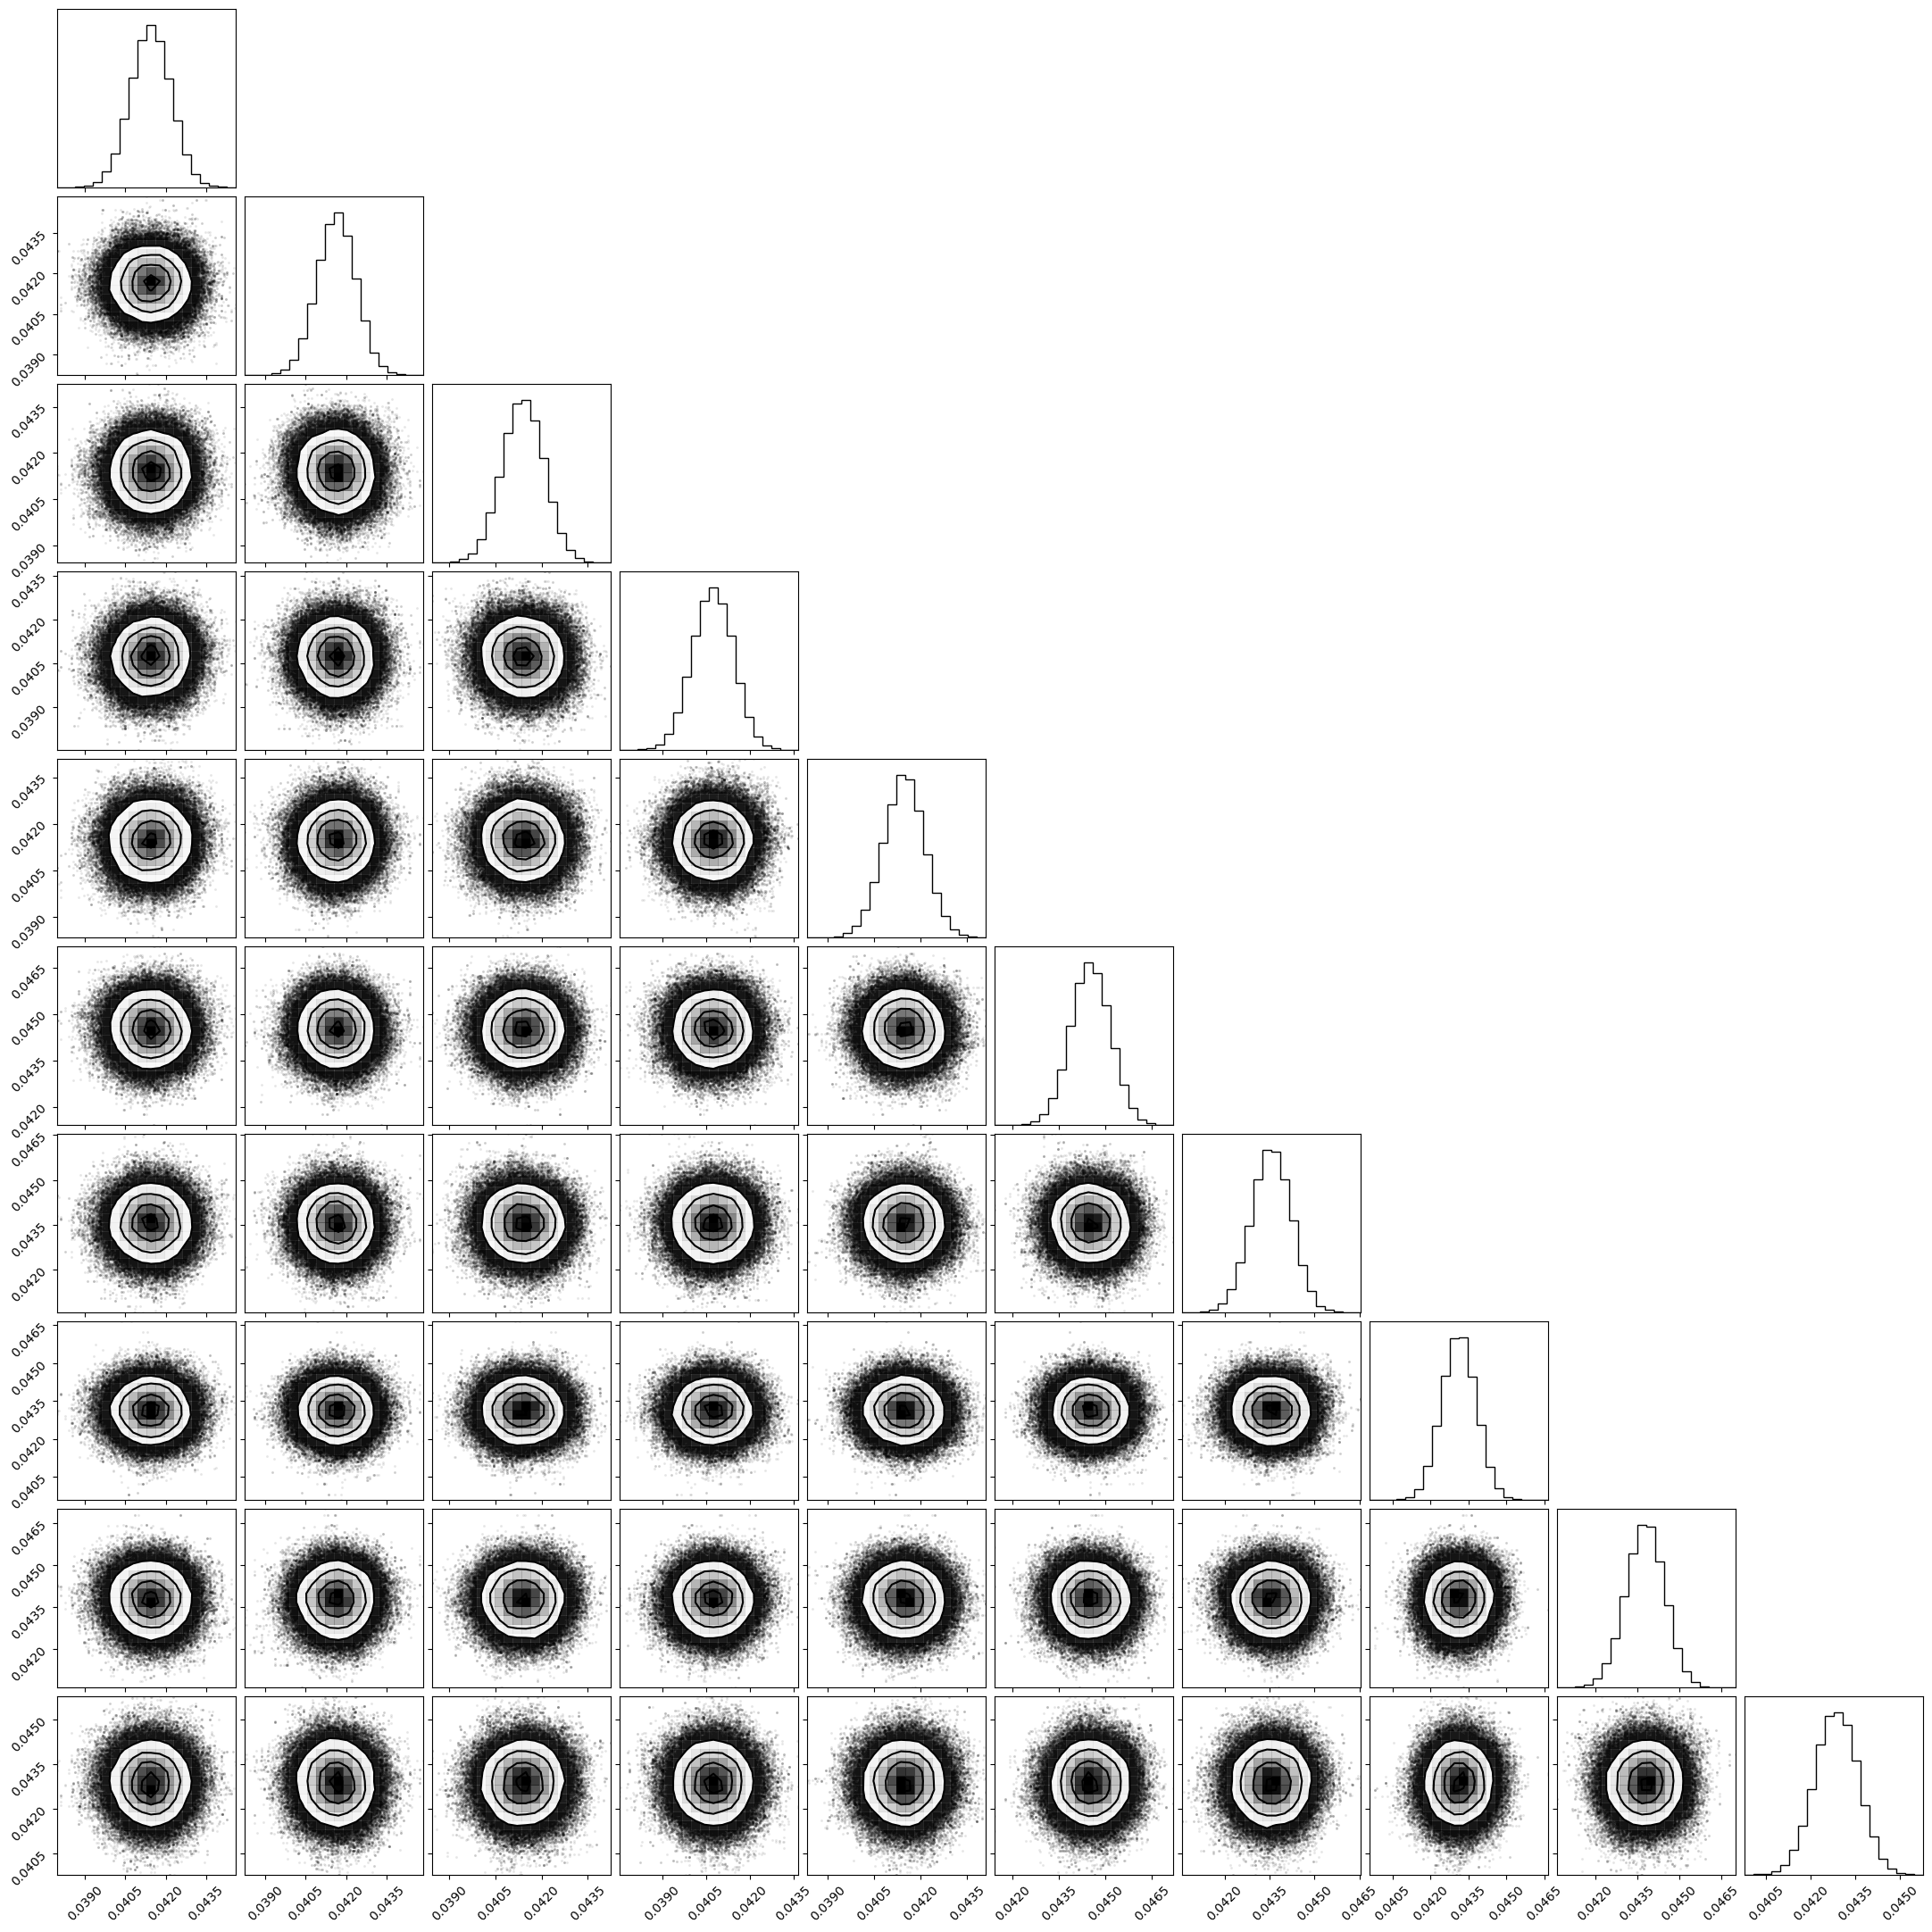

In [10]:
makeCorner = True
if makeCorner:
    cfig = corner.corner(rprs_flatsamples)
    plt.show()

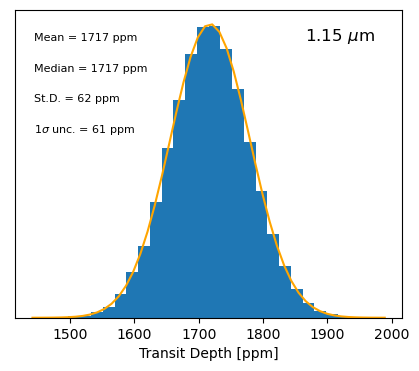

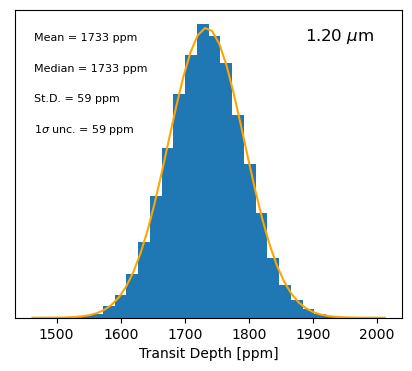

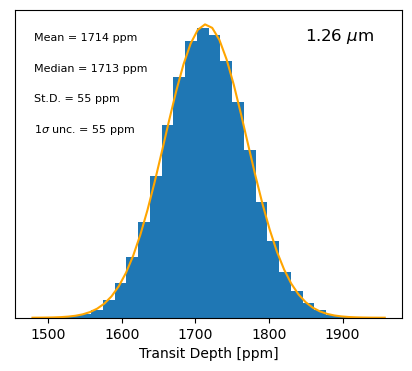

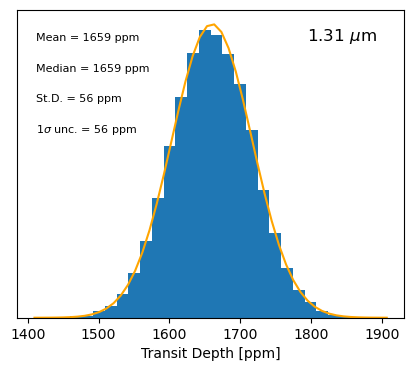

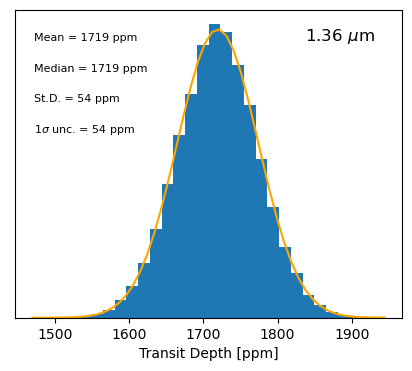

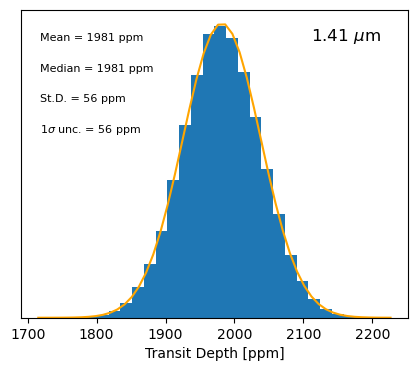

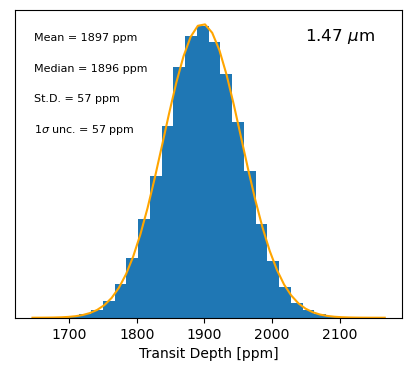

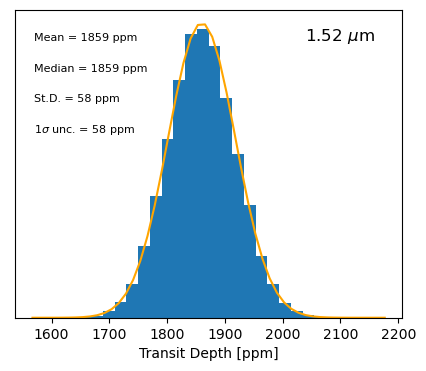

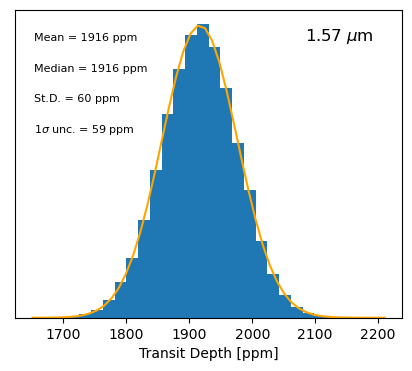

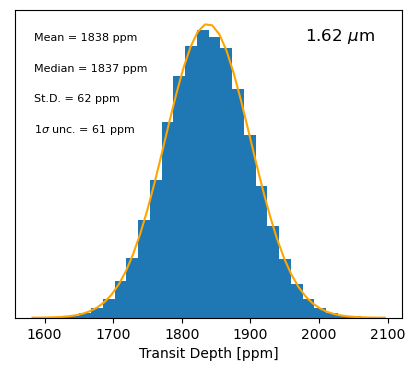

In [11]:
makeGaussPlots = True
if makeGaussPlots:
    for wav in range(Nwaves):
        fig, ax = plt.subplots(figsize=(5,4))
        ax.text(0.75, 0.9, r'%.2f $\mu$m'%(wavelengths[wav]), fontsize=12, c='black', transform=ax.transAxes)
        rprschain = rprs_flatsamples[:,wav]
        dchain = rprschain ** 2.
        dchain *= 1.e6  # converts to [ppm]
        
        # plot histogram of the samples
        ax.hist(dchain, bins=30, density=True)
        # fit a normal distribution, and plot it too
        mu, sd = norm.fit(dchain)
        median = np.median(dchain)
        up_percentile, lo_percentile = np.percentile(dchain, 84), np.percentile(dchain, 16)
        gauss_err = np.mean(((up_percentile - median), (median - lo_percentile)))
        x_normfit = np.linspace(min(dchain), max(dchain), 50)
        y_normfit = norm.pdf(x_normfit, mu, sd)
        ax.plot(x_normfit, y_normfit, c='orange')
        ax.text(0.05, 0.9, 'Mean = %d ppm'%(mu), transform=ax.transAxes, fontsize=8, c='black')
        ax.text(0.05, 0.8, 'Median = %d ppm'%(median), transform=ax.transAxes, fontsize=8, c='black')
        ax.text(0.05, 0.7, 'St.D. = %d ppm'%(sd), transform=ax.transAxes, fontsize=8, c='black')
        ax.text(0.05, 0.6, r'1$\sigma$ unc. = %d ppm'%(gauss_err), transform=ax.transAxes, fontsize=8, c='black')
        
        
        ax.set_xlabel('Transit Depth [ppm]')
        ax.axes.yaxis.set_visible(False)
        plt.show()
        

In [12]:
depths = np.zeros(Nwaves)
deptherrs = np.copy(depths)
for wav in range(Nwaves):
    if loadChains:
        rprschain = rprs_flatsamples[:,wav]
        dchain = rprschain ** 2.
        depth = np.median(dchain)
        
        d_uperr = np.percentile(dchain, 84) - depth
        d_loerr = depth - np.percentile(dchain, 16)
        derr = np.mean((d_uperr, d_loerr))
    else:
        depth = res['spec'+str(wav)]['fits'][-1] #rprs**2
        derr = res['spec'+str(wav)]['errs'][-1] #depth*(err/rprs)*np.sqrt(2)
    depths[wav] = depth
    deptherrs[wav] = derr
    

    print('Wavelength %.2f'%(wavelengths[wav]))
    print('Depth = %d +/- %d ppm'%(depth*1.e6, derr*1.e6))
print('\n')
avg_deptherr = np.mean(deptherrs*1.e6)
print('Average depth error = %d ppm'%(avg_deptherr))    
photnoise_ratio = avg_deptherr / 60.
print('This is %.2f x the photon noise limit'%(photnoise_ratio))

Wavelength 1.15
Depth = 1717 +/- 61 ppm
Wavelength 1.20
Depth = 1733 +/- 59 ppm
Wavelength 1.26
Depth = 1713 +/- 55 ppm
Wavelength 1.31
Depth = 1659 +/- 56 ppm
Wavelength 1.36
Depth = 1719 +/- 54 ppm
Wavelength 1.41
Depth = 1981 +/- 56 ppm
Wavelength 1.47
Depth = 1896 +/- 57 ppm
Wavelength 1.52
Depth = 1859 +/- 58 ppm
Wavelength 1.57
Depth = 1916 +/- 59 ppm
Wavelength 1.62
Depth = 1837 +/- 61 ppm


Average depth error = 58 ppm
This is 0.97 x the photon noise limit


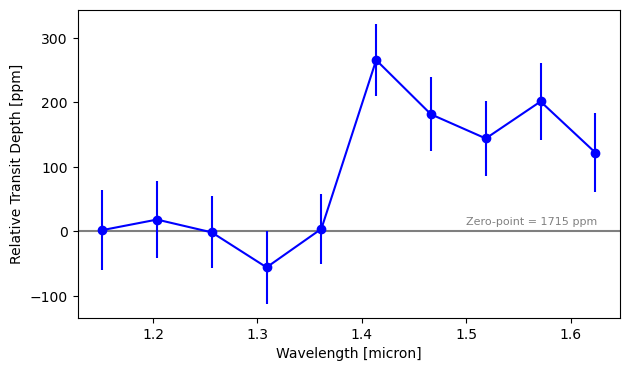

In [14]:
fig, ax = plt.subplots(figsize=(7,4))

med_depth = np.median(depths[np.where(wavelengths <= 1.35)[0]]) * 1.e6
ax.axhline(0., c='black', alpha=0.5)
ax.text(1.5, 10, 'Zero-point = %d ppm'%(med_depth), c='black', alpha=0.5, fontsize=8)
ax.errorbar(wavelengths, depths*1.e6 - med_depth, yerr=deptherrs*1.e6, c='blue', marker='o')
#ax.legend(loc='lower right', fontsize=9)
ax.set_xlabel('Wavelength [micron]')
ax.set_ylabel('Relative Transit Depth [ppm]')
plt.savefig('./figures/TransmissionSpectrum_10bins.png', dpi=450, bbox_inches='tight')
plt.show()

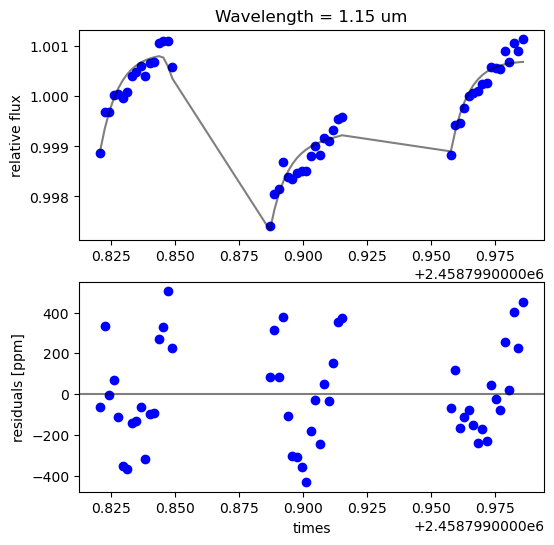

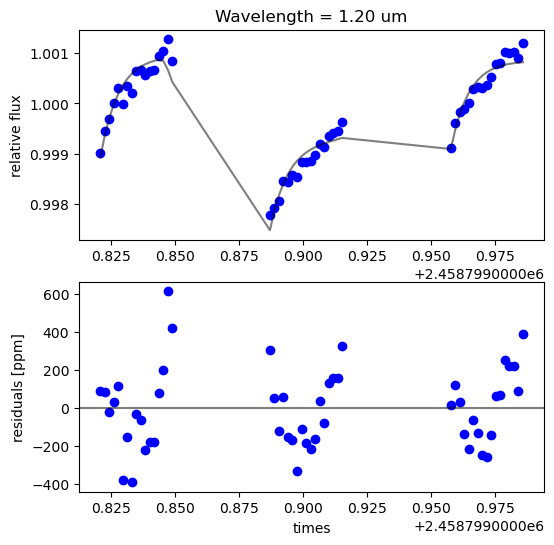

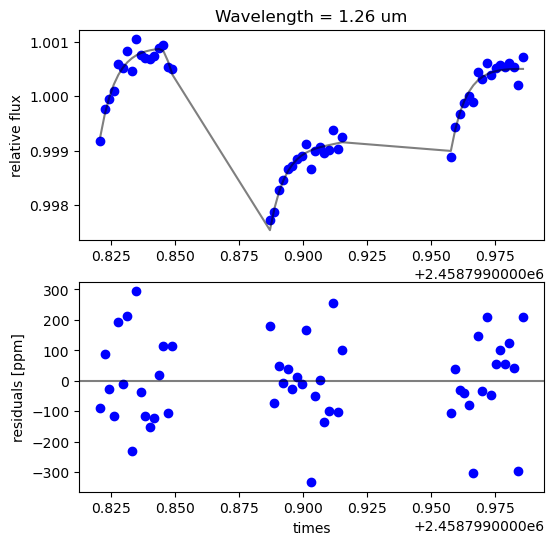

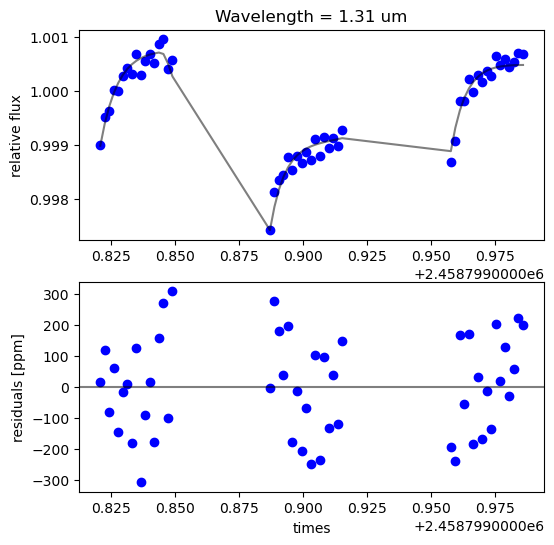

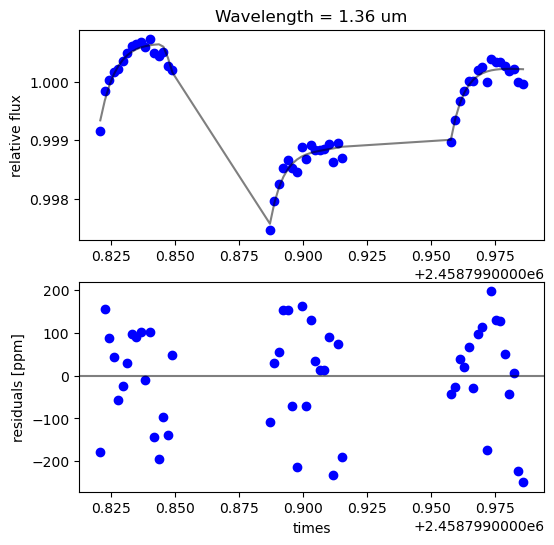

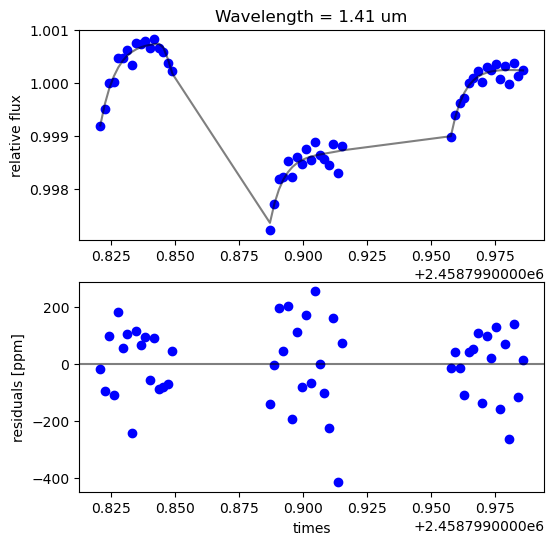

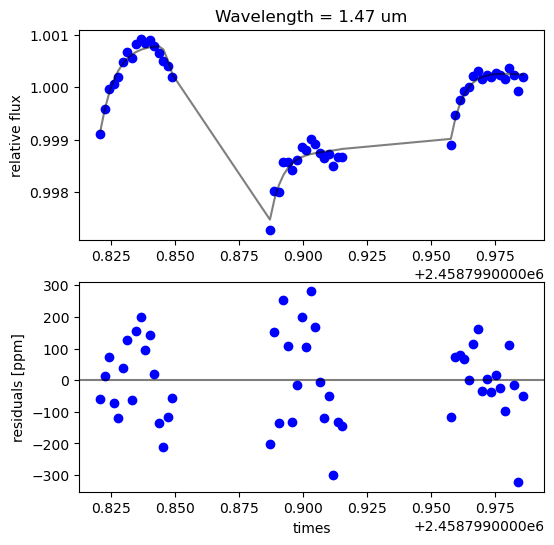

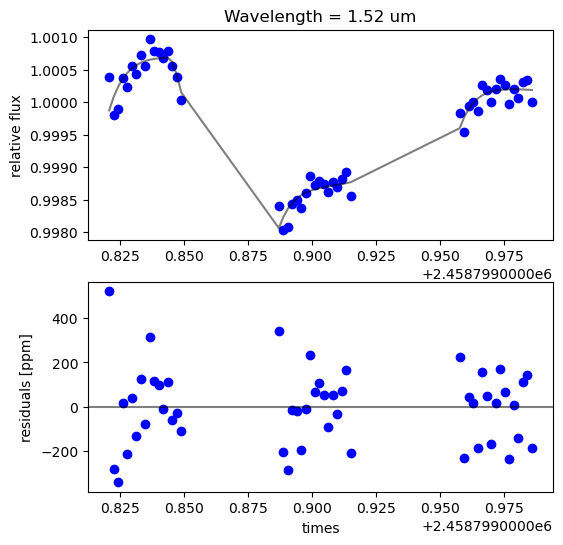

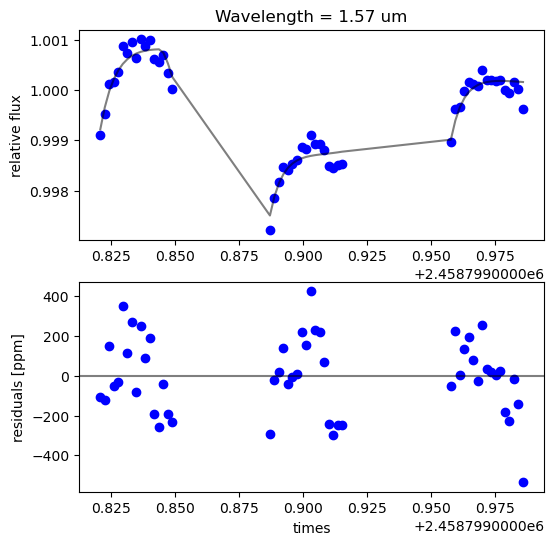

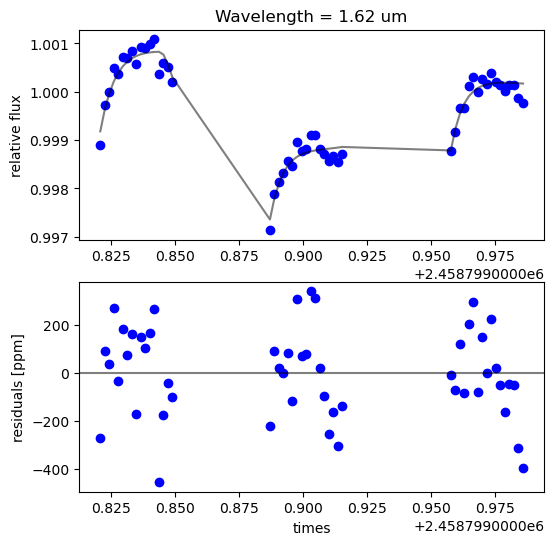

In [15]:
# Plotting raw light curves
for wav in range(Nwaves):
    params = res['spec'+str(wav)]['fits']
    
    tran = transit(params[0], BATMAN_initmodel)
    hoo = hook(params, t_orbit)
    ram = ramp(params, t_visit)
    model = tran * hoo * ram
    resids = fluxes[wav, :] - model
    
    fig, ax = plt.subplots(figsize=(6,6), nrows=2)
    ax[0].set_title('Wavelength = %.2f um'%(wavelengths[wav]))
    # plotting the flux data and model
    ax[0].plot(times, model, c='black', alpha=0.5)
    ax[0].scatter(times, fluxes[wav,:], c='blue')
    ax[0].set_ylabel('relative flux')
    # plotting the residuals
    ax[1].axhline(0., c='black', alpha=0.5)
    ax[1].scatter(times, resids*1.e6, c='blue')
    ax[1].set_ylabel('residuals [ppm]')
    ax[1].set_xlabel('times')
    plt.show()

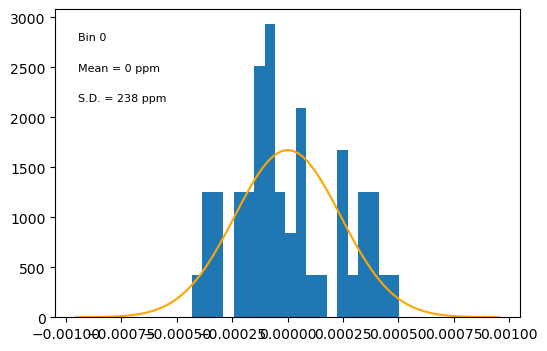

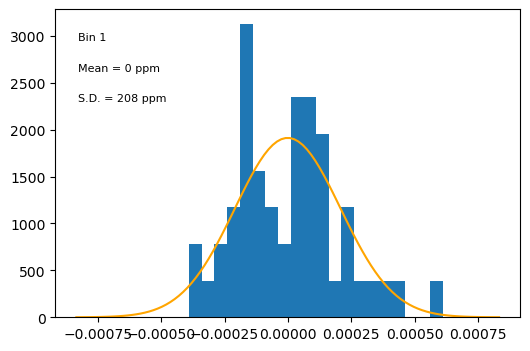

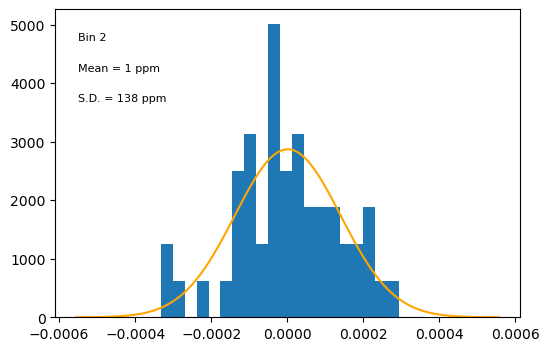

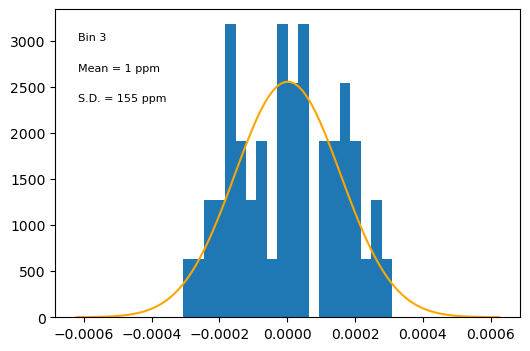

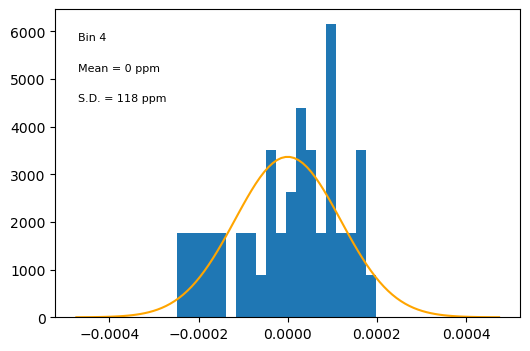

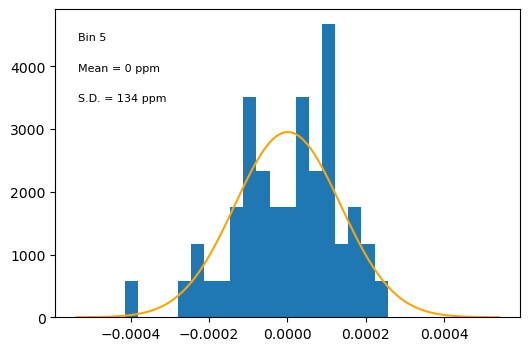

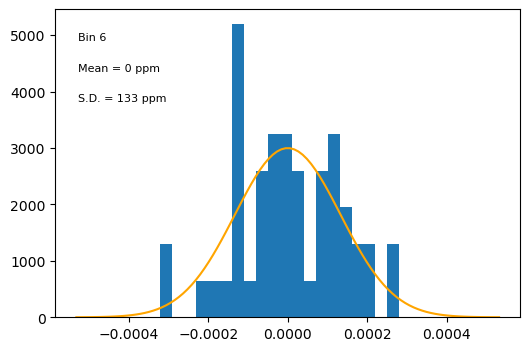

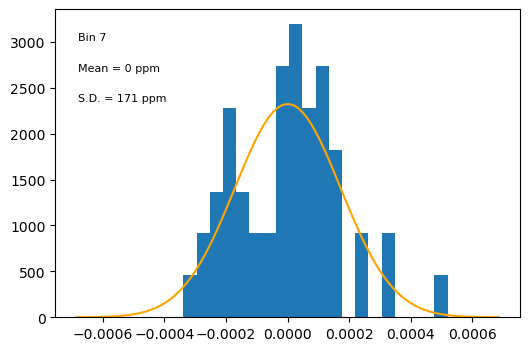

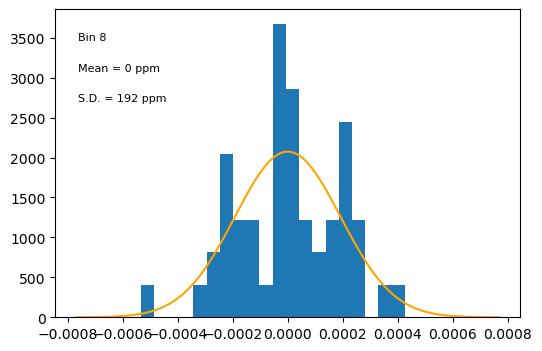

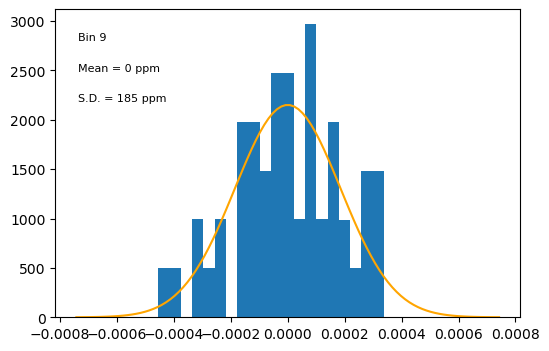

In [16]:
# plotting and fitting the residuals
residual_sd_vals = np.zeros(Nwaves)
for wav in range(Nwaves):
    params = res['spec'+str(wav)]['fits']
    
    tran = transit(params[0], BATMAN_initmodel)
    hoo = hook(params, t_orbit)
    ram = ramp(params, t_visit)
    model = tran * hoo * ram
    resids = fluxes[wav, :] - model
    
    mu, sd = norm.fit(resids)
    residual_sd_vals[wav] = sd
    
    fig, ax = plt.subplots(figsize=(6,4))
    ax.hist(resids, bins=20, density=True)
    xpdf = np.linspace((mu-4.*sd), (mu+4.*sd), 100)
    ypdf = norm.pdf(xpdf, mu, sd)
    ax.plot(xpdf, ypdf, c='orange')
    ax.text(0.05, 0.9, 'Bin %d'%(wav), c='black', fontsize=8, transform=ax.transAxes)
    ax.text(0.05, 0.8, 'Mean = %d ppm'%(mu*1.e6), c='black', fontsize=8, transform=ax.transAxes)
    ax.text(0.05, 0.7, 'S.D. = %d ppm'%(sd*1.e6), c='black', fontsize=8, transform=ax.transAxes)
    plt.show()
    
    
    
#     fig, ax = plt.subplots(figsize=(6,6), nrows=2)
#     # plotting the flux data and model
#     ax[0].plot(times, model, c='black', alpha=0.5)
#     ax[0].scatter(times, fluxes[wav,:], c='blue')
#     ax[0].set_ylabel('relative flux')
#     # plotting the residuals
#     ax[1].axhline(0., c='black', alpha=0.5)
#     ax[1].scatter(times, resids*1.e6, c='blue')
#     ax[1].set_ylabel('residuals [ppm]')
#     ax[1].set_xlabel('times')
#     plt.show()

In [17]:
resid_level = np.mean(residual_sd_vals)
print('Residual level = %d ppm'%(resid_level*1.e6))

Residual level = 167 ppm


In [18]:
import matplotlib


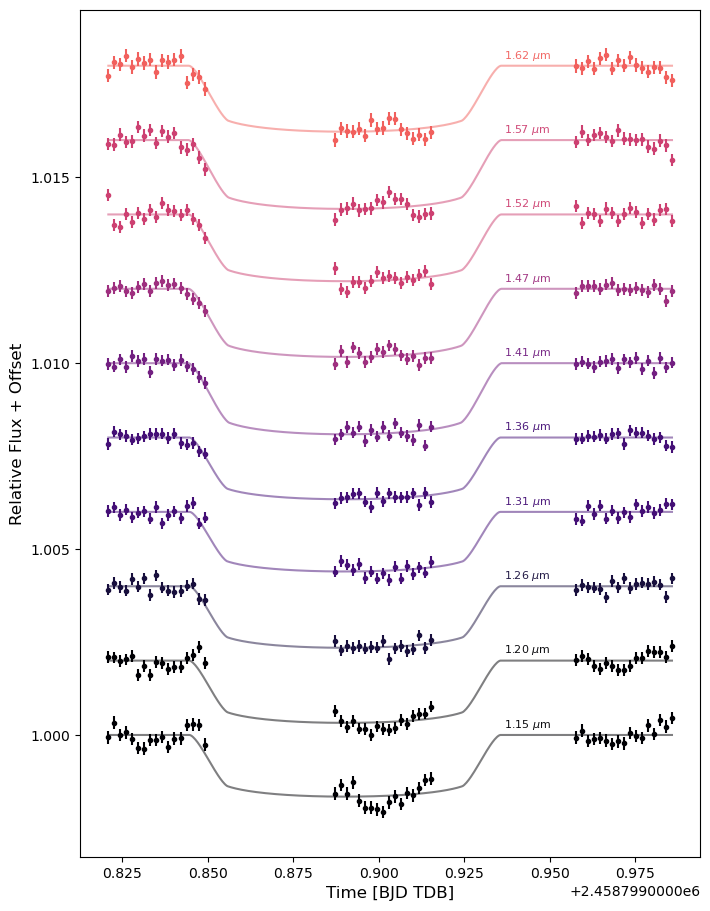

In [19]:
# Plotting detrended light curves
# Initializing the BATMAN model
PlottingParams = batman.TransitParams()
PlottingParams.t0 = t0_fixed     
PlottingParams.per = P_fixed
PlottingParams.a = a_fixed
PlottingParams.inc = inc_fixed
PlottingParams.rp = rprs_init
PlottingParams.ecc = ecc_fixed
PlottingParams.w = w_fixed
PlottingParams.limb_dark = 'quadratic'
PlottingParams.u = u_fixed
times_for_plotting = np.linspace(times[0], times[-1], 500)
BATMAN_plotmodel = batman.TransitModel(PlottingParams, times_for_plotting)

cmap = matplotlib.cm.get_cmap('magma', Nwaves)
wavecolors = cmap(np.linspace(0, 1, Nwaves+5))

fig, ax = plt.subplots(figsize=(8,11))
offset = 0.
for wav in range(Nwaves):
    params = res['spec'+str(wav)]['fits']
    rprs = params[0]
    PlottingParams.rp = rprs
    lc = BATMAN_plotmodel.light_curve(PlottingParams)
    
    hoo = hook(params, t_orbit)
    ram = ramp(params, t_visit)
    systematics = hoo * ram
    det_flux = fluxes[wav,:] / systematics
    det_err = errors[wav,:] / systematics
    
    ax.text(times_for_plotting[350], 1.0002 + offset, r'%.2f $\mu$m'%(wavelengths[wav]), fontsize=8, alpha=0.95, c=wavecolors[wav])
    ax.plot(times_for_plotting, lc + offset, alpha=0.5, c=wavecolors[wav])
    ax.errorbar(times, det_flux + offset, det_err, ls='None', marker='o', ms=3, c=wavecolors[wav])
    
    offset += 0.002
    
ax.set_xlabel('Time [BJD TDB]', fontsize=12)
ax.set_ylabel('Relative Flux + Offset', fontsize=12)
#plt.savefig('./figures/DetrendedSpectralLightcurves.png', dpi=450, bbox_inches='tight')
plt.show()

In [20]:
wfc3_low = 1.1250
wfc3_high = 1.650
bin_width_pred = (wfc3_high - wfc3_low) / len(wavelengths)
print('predicted bin width = ', bin_width_pred)

bin_width_calc = (wavelengths[1] - wavelengths[0])
print('approx calc bin width = ', bin_width_calc)

predicted bin width =  0.05249999999999999
approx calc bin width =  0.05249999999999999


In [21]:
approx_bin_widths = np.zeros(len(wavelengths))
for i, wav in enumerate(wavelengths):
    if i == 0:
        continue
    approx_bin_widths[i] = wavelengths[i] - wavelengths[i-1]
approx_bin_widths[0] = np.median(approx_bin_widths) # the widths are all the same anyways

In [22]:
depths*1.e6

array([1717.31755792, 1733.71766257, 1713.84971336, 1659.61732578,
       1719.35892687, 1981.05696731, 1896.92710899, 1859.4621719 ,
       1916.80207332, 1837.51998278])

In [23]:
## Saving the data to a .txt file for the retrieval
saveTxt = True
if saveTxt:
    # saving the transmission spectrum as plotted above
    # saved column formats: Bin Wavelength [micron], Bin Width [micron], Transit Depth (Rp/Rs)^2, Transit Depth Uncertainty
    sfilename = 'hd219666b_tspecdata_10bins.txt'
    sfile = open(sfilename, 'w')
    sfile.write('# Bin Wavelength [micron], Bin Width [micron], Transit Depth (Rp/Rs)^2, Transit Depth Uncertainty \n')
    for i, point in enumerate(wavelengths):
        sfile.write(str(wavelengths[i])) # bin wavelength [micron]
        sfile.write(' ')
        sfile.write(str(approx_bin_widths[i])) # bin widths [micron]
        sfile.write(' ')
        sfile.write(str(depths[i]))  # transit depth (Rp/Rs)^2
        sfile.write(' ')
        sfile.write(str(deptherrs[i]))  # transit depth uncertainty
        sfile.write('\n')
    sfile.close()

    print('saved!')

saved!
